In [26]:
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import HumanMessage,SystemMessage
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel,Field
from typing import TypedDict,Literal,Annotated,List
import operator

from dotenv import load_dotenv

In [27]:
load_dotenv()

generator_llm=ChatOpenAI(model='gpt-4o-mini',temperature=0)
evaluator_llm=ChatOpenAI(model='gpt-4o-mini',temperature=0)
optimizer_llm=ChatOpenAI(model='gpt-4o-mini',temperature=0)

In [28]:
class TweetEvaluation(BaseModel):
    evaluation:Literal['approved','needs_improvement'] = Field(...,description='The evaluation of the tweet')
    feedback:str = Field(...,description='The feedback for the tweet')


In [29]:
structured_evaluator_llm=evaluator_llm.with_structured_output(TweetEvaluation)

In [30]:
class TweetState(TypedDict):
    topic:str
    tweet:str
    evaluation:Literal['approved','needs_improvement']
    feedback:str
    iteration:int
    max_iterations:int

    tweet_history:Annotated[List[str],operator.add]
    feedback_history:Annotated[List[str],operator.add]

In [31]:
# define generator node
def generator_node(state:TweetState):

    messages=[
        SystemMessage(content=f'You are a social media expert and you are genearting {state["topic"]} post for a twitter account'),
        HumanMessage(content=f"""
                            Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

                            Rules:
                            - Do NOT use question-answer format.
                            - Max 280 characters.
                            - Use observational humor, irony, sarcasm, or cultural references.
                            - Think in meme logic, punchlines, or relatable takes.
                            - Use simple, day to day english
                            """)]
 
    response=generator_llm.invoke(messages)

    return{'tweet':response.content}

def evaluator_node(state:TweetState):

    messages=[
        SystemMessage(content=f'You are a social media expert and you are evaluating a tweet on the topic: "{state['topic']}"'),
        HumanMessage(content=f""" Evaluate the following tweet:

                                Tweet: "{state['tweet']}"

                                Use the criteria below to evaluate the tweet:

                                1. Originality – Is this fresh, or have you seen it a hundred times before?  
                                2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
                                3. Punchiness – Is it short, sharp, and scroll-stopping?  
                                4. Virality Potential – Would people retweet or share it?  
                                5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

                                Auto-reject if:
                                - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
                                - It exceeds 280 characters
                                - It reads like a traditional setup-punchline joke
                                - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

                                ### Respond ONLY in structured format:
                                - evaluation: "approved" or "needs_improvement"  
                                - feedback: One paragraph explaining the strengths and weaknesses 
                                """)]

    response=structured_evaluator_llm.invoke(messages)

    return{'evaluation':response.evaluation,'feedback':response.feedback, 'feedback_history':[response.feedback]}


def optimizer_node(state:TweetState):

    messages=[
        SystemMessage(content=f'You are a social media expert and you are optimizing a tweet on the topic: "{state['topic']}"'),
        HumanMessage(content=f"""
                                Improve the tweet based on this feedback:
                                "{state['feedback']}"

                                Topic: "{state['topic']}"
                                Original Tweet:
                                {state['tweet']}

                                Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
                                """)]
    response=generator_llm.invoke(messages)
    iteration=state['iteration']+1

    return{'tweet':response.content,'tweet_history':[response.content],'iteration':iteration}


def router_evaluation(state:TweetState):
    if state['evaluation']=='approved' or state['iteration']>=state['max_iterations']:
        return 'approved'
    else:
        return 'needs_improvement'



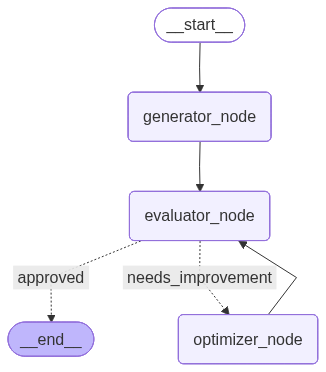

In [32]:
graph=StateGraph(TweetState)

graph.add_node('generator_node',generator_node)
graph.add_node('evaluator_node',evaluator_node)
graph.add_node('optimizer_node',optimizer_node)

graph.add_edge(START, 'generator_node')
graph.add_edge('generator_node', 'evaluator_node')
graph.add_conditional_edges('evaluator_node',router_evaluation,{'approved':END,'needs_improvement':'optimizer_node'})
graph.add_edge('optimizer_node', 'evaluator_node')

workflow=graph.compile()

workflow

In [37]:
initial_state={'topic':'AI',
                'iteration':0,  
                'max_iterations':3}

result=workflow.invoke(initial_state)


In [38]:
result

{'topic': 'AI',
 'tweet': 'Just taught my AI to make coffee. Now it’s judging my life choices while brewing. Great, I’ve got a robot barista and a therapist in one. Next, I’ll program it to remind me of my ex’s birthday. #AI #LifeChoices ☕🤖',
 'evaluation': 'approved',
 'feedback': "This tweet is original and creatively combines the concepts of AI, coffee-making, and personal reflection, which makes it stand out. The humor is relatable and likely to resonate with many, as it touches on the common experience of seeking comfort in technology. The punchiness is effective, as it is concise and engaging, making it easy to read and share. The use of hashtags enhances its visibility, and the format adheres to Twitter's guidelines, making it a well-formed tweet. Overall, it has strong virality potential due to its humorous take on everyday life with AI.",
 'iteration': 0,
 'max_iterations': 3,
 'tweet_history': [],
 'feedback_history': ["This tweet is original and creatively combines the conce